In [1]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import DataLoader
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from torch import nn
import wandb

In [3]:
DATA_ROOT = "../data/CAIA"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
WANDB_API_KEY = os.environ.get("WANDB_API_KEY")
wandb.login(key=WANDB_API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dinhchicongf9. Use `wandb login --relogin` to force relogin


True

# I.Data

In [5]:
TARGET_SIZE = (360, 640) # h, w
CHANNELS = 4
ACCUMULATING_GRADIENT = 4

Preprocess

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize tất cả hình ảnh về 224x224 để phù hợp với đầu vào của ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Sử dụng giá trị mean và std của ImageNet
])

Load data

In [7]:
BATCH_SIZE = 512

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)
                
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
training_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/train", transform=transform)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
val_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/val", transform=transform)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
test_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/test", transform=transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.6158917].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7154248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7589979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7055321].


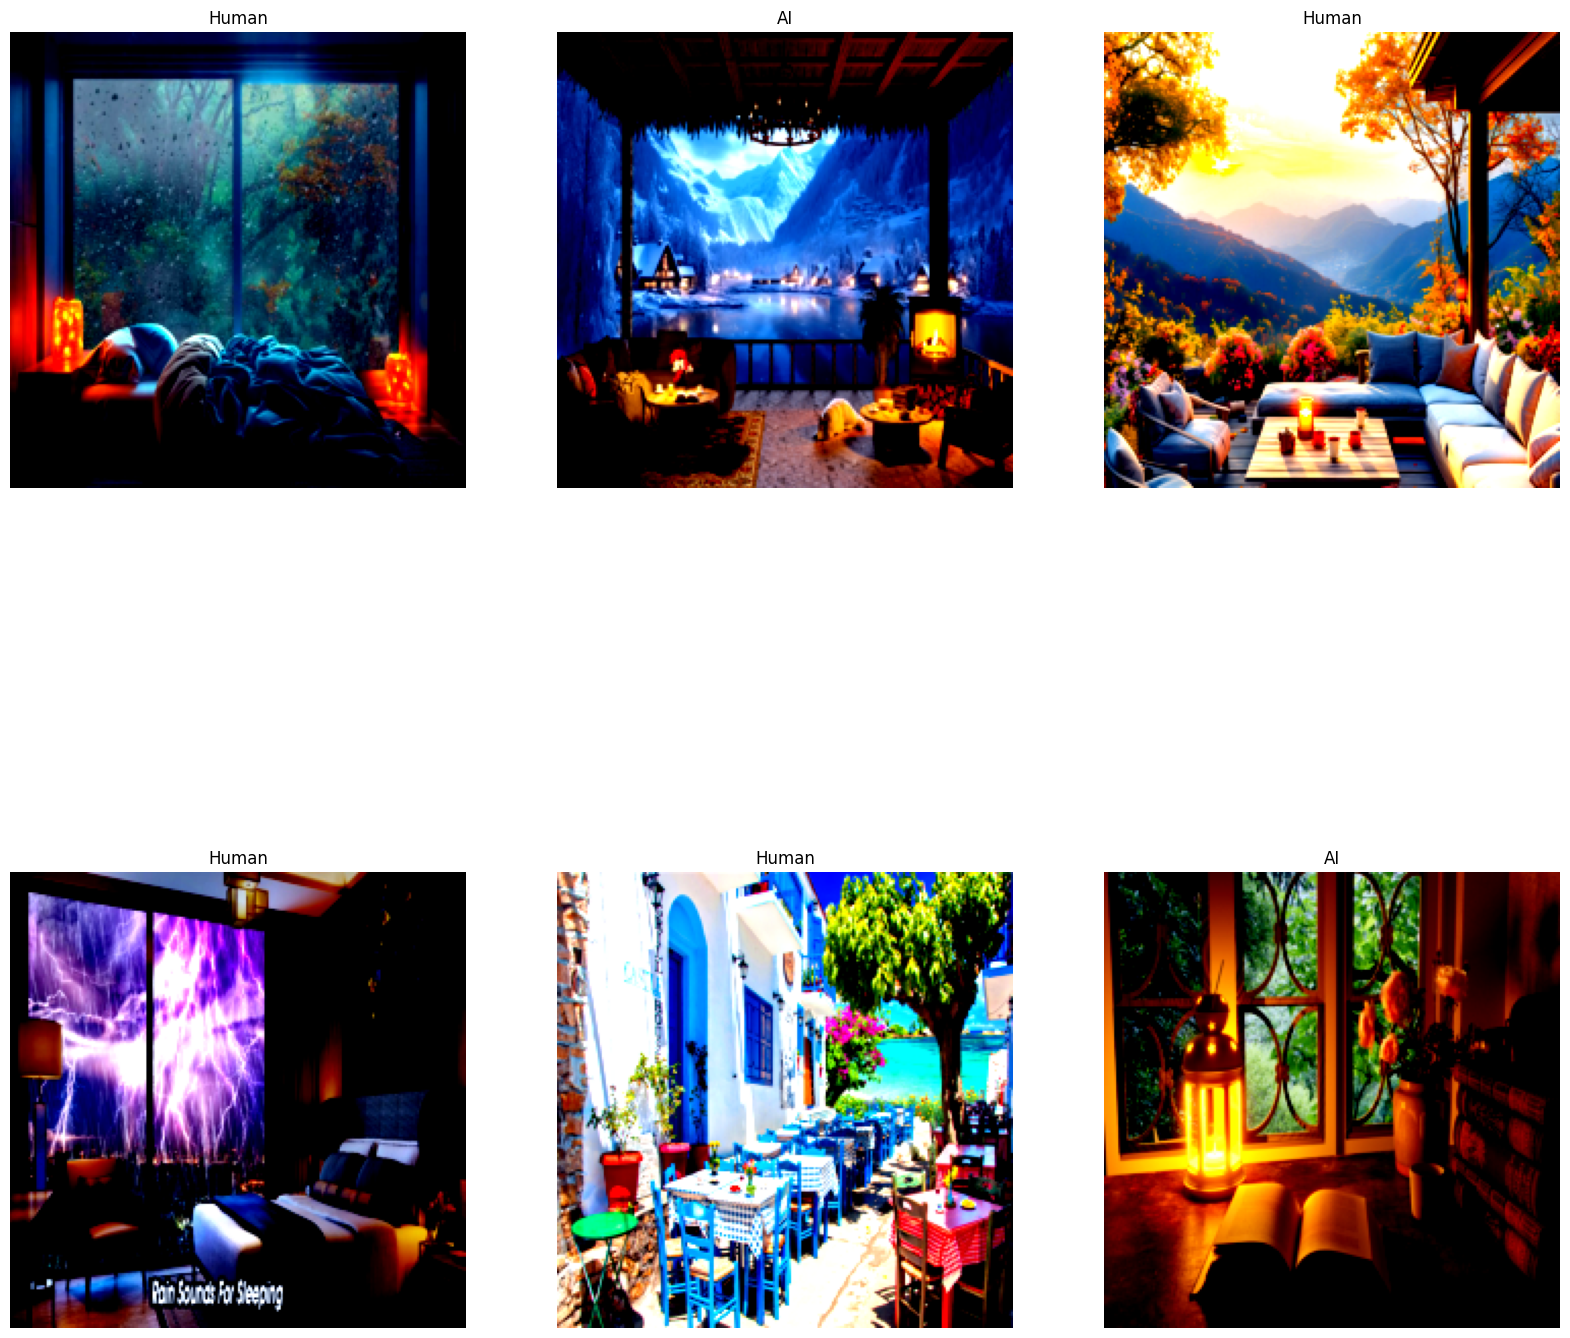

In [12]:
labels_map = {
    0: "AI",
    1: "Human",
}
figure = plt.figure(figsize=(20, 20))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # Chuyển đổi từ (C, H, W) sang (H, W, C)
    img = (img * 0.5) + 0.5  # Undo normalization
    plt.imshow(img)

# II. Build model

In [13]:
# output_height = (input_height + 2 * padding - kernel_size) // stride + 1
# output_width = (input_width + 2 * padding - kernel_size) // stride + 1

In [14]:
pretrained_model = models.resnet152(pretrained = True)
for param in pretrained_model.parameters():
    param.requires_grad = False

/home/congdc/miniconda3/envs/caia/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/congdc/miniconda3/envs/caia/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
class ArtClsModel(nn.Module):
    def __init__(self, pretrained_model) -> None:
        super(ArtClsModel, self).__init__()
        
        self.features = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        classifiction_input = pretrained_model.fc.in_features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(classifiction_input, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        logits = self.classifier(x)
        return logits
    

In [16]:
model = ArtClsModel(pretrained_model).to(DEVICE)
# print(model)

params

In [17]:
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

# III. Train

In [18]:
LEARNING_RATE = 1e-2
EPOCHS = 200
VAL_EPOCH = 5
TEST_EPOCH = 50

In [19]:
wandb.init(
    # set the wandb project where this run will be logged
    project="classification-model_ai-art",
    name="v0.1",
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "CAIA-model",
    "dataset": "CAIA-dataset",
    "train_epochs": EPOCHS,
    "val_per_epochs": VAL_EPOCH,  
    "test_per_epochs": TEST_EPOCH,
    }
)


In [20]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

In [21]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    for idx_batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        y = y.unsqueeze(1).float()
        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)
        
        loss.backward()
        
        # show log
        loss, current = loss.item(), idx_batch * len(X)
        wandb.log({"train_loss": loss})
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Backpropagation
        optimizer.zero_grad()
        optimizer.step()
        
            
            
def val_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y = y.unsqueeze(1)
            pred = model(X)
            test_loss += criterion(pred, y.float()).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    wandb.log({"val_loss": test_loss})
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y = y.unsqueeze(1)
            pred = model(X)
            test_loss += criterion(pred, y.float()).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    wandb.log({"test_loss": test_loss})
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, criterion, optimizer)
    
    if t % VAL_EPOCH == 0:
        val_loop(val_dataloader, model, criterion)
    
    if t % TEST_EPOCH == 0:
        test_loop(test_dataloader, model, criterion)
        
print("Done!")

Epoch 1
-------------------------------
loss: 0.701765  [    0/ 1600]
loss: 0.693835  [  512/ 1600]
loss: 0.692964  [ 1024/ 1600]
loss: 0.705284  [  192/ 1600]
Val Error: 
 Accuracy: 59.8%, Avg loss: 0.683679 

Test Error: 
 Accuracy: 62.9%, Avg loss: 0.674395 

Epoch 2
-------------------------------
loss: 0.696507  [    0/ 1600]
loss: 0.696172  [  512/ 1600]
loss: 0.699431  [ 1024/ 1600]
loss: 0.683965  [  192/ 1600]
Epoch 3
-------------------------------
loss: 0.690510  [    0/ 1600]
loss: 0.695673  [  512/ 1600]
loss: 0.697795  [ 1024/ 1600]
loss: 0.691718  [  192/ 1600]
Epoch 4
-------------------------------
loss: 0.700325  [    0/ 1600]
loss: 0.699752  [  512/ 1600]
loss: 0.692942  [ 1024/ 1600]
loss: 0.692890  [  192/ 1600]
Epoch 5
-------------------------------
loss: 0.698989  [    0/ 1600]
loss: 0.697958  [  512/ 1600]
loss: 0.694787  [ 1024/ 1600]
loss: 0.685998  [  192/ 1600]
Epoch 6
-------------------------------
loss: 0.696222  [    0/ 1600]
loss: 0.693970  [  512/ 160

KeyboardInterrupt: 

In [ ]:
wandb.finish()

test_loss,▁███
train_loss,▃▃▆▃▃█▃▃▁▃▆▆▆▁▆▃▃▁▃▃▃▃█▆▆▃▁▃▃▆▃▃▆▃▆▆█▃█▆
val_loss,███▁█▁█▁██▁▁█▁█▁▁▁▁▁▁▁██▁█▁▁▁▁▁█▁█▁██▁▁█
test_loss,20.86957
train_loss,66.66667
val_loss,39.28572


In [ ]:
 torch.save(model.state_dict(), '../checkpoints/output_model.pth')